# Homework 4
# Autor: Antonio Castañares Rodríguez, A20599898
___

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds
import tensorflow as tf
import cv2

from tensorflow import keras
from keras import Sequential, layers
from keras.models import load_model
from keras.preprocessing.image import load_img, img_to_array
from matplotlib import pyplot
from matplotlib.patches import Rectangle
from sklearn.metrics import precision_recall_curve, auc

## Auxiliary functions:

In [2]:
# EXERCISE 1: This function receives each element of the dataset and returns it resized and normalized
def preprocess(sample):
    # Extract the image and mask from the sample
    image = sample['image']
    mask = sample['segmentation_mask']

    # Resized and normalized its image and mask
    image = tf.image.resize(image, (128, 128))
    image = tf.cast(image, tf.float32) / 255.0

    mask = tf.image.resize(mask, (128, 128))
    mask = tf.cast(mask, tf.int32) - 1

    return image, mask

# EXERCISE 2: Get the box of the animal
def get_bounding_box(mask):
    pet = np.argwhere(mask == 0)[:, :2]
    # Get the minimum and maximum x and y coordinates
    ymin, xmin = pet.min(axis=0)
    ymax, xmax = pet.max(axis=0)

    # Return the bounding box coordinates
    return xmin, ymin, xmax, ymax

# EXERCISE 2: Plot the box into the image
def draw_boxes(image,boxes):
    xmin, ymin, xmax, ymax = boxes[0]

    # Draw the bounding box on the image
    plt.figure()
    plt.title('Original image with bounding box')
    plt.imshow(image)
    plt.plot([xmin, xmax, xmax, xmin, xmin], [ymin, ymin, ymax, ymax, ymin], 'r')
    plt.axis('off')
    plt.show()

# EXERCISE 2 YOLO: Class for the boxes
class BoundBox:
	def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
		self.xmin = xmin
		self.ymin = ymin
		self.xmax = xmax
		self.ymax = ymax
		self.objness = objness
		self.classes = classes
		self.label = -1
		self.score = -1

	def get_label(self):
		if self.label == -1:
			self.label = np.argmax(self.classes)

		return self.label

	def get_score(self):
		if self.score == -1:
			self.score = self.classes[self.get_label()]

		return self.score

# EXERCISE 2 YOLO: Function sigmoid
def _sigmoid(x):
	return 1. / (1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh

	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
      if x4 < x1:
        return 0
      else:
        return min(x2,x4) - x1
    else:
      if x2 < x3:
        return 0
      else:
        return min(x2,x4) - x3

def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union

def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# load and prepare an image
def load_image_pixels(filename, shape):
	# load the image to get its shape
	image = load_img(filename)
	width, height = image.size
	# load the image with the required size
	image = load_img(filename, target_size=shape)
	# convert to numpy array
	image = img_to_array(image)
	# scale pixel values to [0, 1]
	image = image.astype('float32')
	image /= 255.0
	# add a dimension so that we have one sample
	image = np.expand_dims(image, 0)
	return image, width, height

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes_yolo(filename, v_boxes, v_labels, v_scores):
	# load the image
	data = pyplot.imread(filename)
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='white')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='white')
	# show the plot
	pyplot.show()

 # Load the ground truth and predictions
def load_labels(filename):
    labels = {}
    with open(filename, 'r') as f:
        for line in f:
            parts = line.strip().split()
            image_id = parts[0]
            bbox = list(map(float, parts[1].split(',')))[:4]
            class_id = int(parts[1].split(',')[4])
            confidence = float(parts[1].split(',')[5]) if len(parts[1].split(',')) > 5 else None
            if image_id not in labels:
                labels[image_id] = []
            labels[image_id].append({
                "bbox": bbox,
                "class_id": class_id,
                "confidence": confidence
            })
    return labels

# IoU calculation function
def calculate_iou(box1, box2):
    x1 = max(box1[0], box2[0])
    y1 = max(box1[1], box2[1])
    x2 = min(box1[2], box2[2])
    y2 = min(box1[3], box2[3])

    intersection_area = max(0, x2 - x1) * max(0, y2 - y1)
    box1_area = (box1[2] - box1[0]) * (box1[3] - box1[1])
    box2_area = (box2[2] - box2[0]) * (box2[3] - box2[1])
    union_area = box1_area + box2_area - intersection_area

    return intersection_area / union_area if union_area != 0 else 0

# Evaluate mAP at different IoU thresholds
def evaluate_mAP(gt_labels, pred_labels, iou_thresholds=[0.25, 0.5, 0.75, 0.95]):
    mAP_results = {}

    for iou_threshold in iou_thresholds:
        tp, fp, scores = [], [], []
        total_ground_truths = 0

        # Iterate over each image in the ground truth labels
        for image_id, gt_boxes in gt_labels.items():
            total_ground_truths += len(gt_boxes)
            pred_boxes = pred_labels.get(image_id, [])

            used_gt = set()
            image_tp = []
            image_fp = []
            image_scores = []

            # Sort predictions by confidence for this image
            for pred_box in sorted(pred_boxes, key=lambda x: x["confidence"], reverse=True):
                pred_bbox = pred_box["bbox"]
                pred_confidence = pred_box["confidence"]

                best_iou = 0
                best_gt_index = -1

                # Match the prediction to the best ground truth box based on IoU
                for gt_index, gt_box in enumerate(gt_boxes):
                    if gt_index in used_gt:
                        continue
                    iou = calculate_iou(pred_bbox, gt_box["bbox"])
                    if iou > best_iou:
                        best_iou = iou
                        best_gt_index = gt_index

                # Determine if the prediction is TP or FP based on IoU threshold
                if best_iou >= iou_threshold:
                    image_tp.append(1)
                    image_fp.append(0)
                    used_gt.add(best_gt_index)
                else:
                    image_tp.append(0)
                    image_fp.append(1)
                image_scores.append(pred_confidence)

            # Append the results for this image to the main lists
            tp.extend(image_tp)
            fp.extend(image_fp)
            scores.extend(image_scores)

        # Calculate Precision-Recall and Average Precision (AP)
        tp_cumsum = np.cumsum(tp)
        fp_cumsum = np.cumsum(fp)
        recall = tp_cumsum / total_ground_truths
        precision = tp_cumsum / (tp_cumsum + fp_cumsum + 1e-10)
        ap = auc(recall, precision)
        mAP_results[iou_threshold] = ap

    return mAP_results


# First question - Semantic Segmentation

In [3]:
# Load the Oxford Pet Dataset with info and not supervised
dataset, info = tfds.load('oxford_iiit_pet', with_info=True, as_supervised=False)

Use the oxford_iiit_pet dataset from Keras or PyTorch.

- The dataset provides pixel-wise annotations for pets, including two classes: foreground (pet) and background, as well as an additional label for object contours. In this assignment you will ignore the contour labels and focus only on the foreground segmentation.
-The dataset also includes breed-level labels. To simplify, you will convert the pet breed labels into binary cat/dog labels. Assign all cat breeds to the 'cat' category and all dog breeds to the 'dog' category.

Split the dataset into training and testing subsets, then split the training st into a training and validation subset.

Training dataset before split 3680
Training dataset after split 2944
Validation dataset 736
Testing dataset 3669


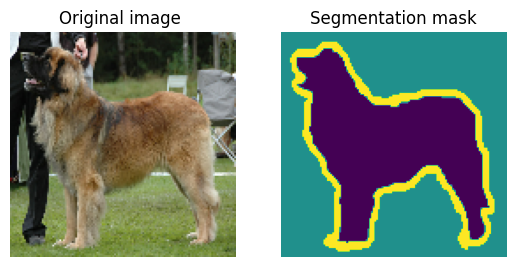

Image shape: (128, 128, 3)
Mask shape: (128, 128, 1)


Basic information about the dataset 
tfds.core.DatasetInfo(
    name='oxford_iiit_pet',
    full_name='oxford_iiit_pet/3.2.0',
    description="""
    The Oxford-IIIT pet dataset is a 37 category pet image dataset with roughly 200
    images for each class. The images have large variations in scale, pose and
    lighting. All images have an associated ground truth annotation of breed.
    """,
    homepage='http://www.robots.ox.ac.uk/~vgg/data/pets/',
    data_dir='/root/tensorflow_datasets/oxford_iiit_pet/3.2.0',
    file_format=tfrecord,
    download_size=773.52 MiB,
    dataset_size=774.69 MiB,
    features=FeaturesDict({
        'file_name': Text(shape=(), dtype=string),
        'image': Image(shape=(None, None, 3), dtype=uint8),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=37),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=uint8),
        'species': ClassLabel(shape=(), dtype=int64, num_clas

In [4]:
# Split into training and testing datasets after preprocessing
train_dataset = dataset['train'].map(preprocess)
test = dataset['test'].map(preprocess)

# Split training dataset into training and validation datasets
train = train_dataset.take(int(0.8 * len(train_dataset)))             # 80% for training of the training set
val = train_dataset.skip(int(0.8 * len(train_dataset)))               # 20% for validation of the training set

print('Training dataset before split', len(train_dataset))
print('Training dataset after split', len(train))
print('Validation dataset', len(val))
print('Testing dataset', len(test))

# Batch the dataset for training
train_batch = train.batch(32)
val_batch = val.batch(32)
test_batch = test.batch(32)

# Example: Access an image and label
random_index = np.random.randint(0, len(train))                       # Choose a random index from the training dataset
image, mask = next(iter(train.skip(random_index).take(1)))  # Skip a random number of elements and take one

# First plot
plt.figure()
plt.subplot(1, 2, 1)
plt.title(f'Original image ')
plt.axis('off')
plt.imshow(image)

# Second plot
plt.subplot(1, 2, 2)
plt.title('Segmentation mask')
plt.imshow(mask)
plt.axis('off')
plt.show()

# Print the shape and mask of the image
print("Image shape:", image.shape)
print("Mask shape:", mask.shape)

# Print some basic information about the dataset
print(f'\n\nBasic information about the dataset \n{info}')

Train a simple convolutional neural network for supervised semantic segmentation (without skip connections).

- Plot the training and validation loss and evaluation metric as a function of epochs.

- Visualize some inference results.

- Provide quantitative training, validation, and testing results

In [5]:
def cnn():
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPool2D(2)(conv1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPool2D(2)(conv2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    pool3 = layers.MaxPool2D(2)(conv3)

    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)

    # Decoder
    up1 = layers.Conv2DTranspose(128, 3, 2,  padding='same')(conv4)
    up2 = layers.Conv2DTranspose(64, 3, 2, padding='same')(up1)
    up3 = layers.Conv2DTranspose(32, 3,2 , padding='same')(up2)
    output = layers.Conv2D(3, 1, padding='same', activation='softmax')(up3)

    return keras.Model(inputs=inputs, outputs=output)

model = cnn()

In [6]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batch,
                    validation_data=val_batch,
                    epochs=5)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 329s 3s/step - accuracy: 0.5934 - loss: 0.8970 - val_accuracy: 0.6069 - val_loss: 0.7930
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 320s 3s/step - accuracy: 0.6823 - loss: 0.7378 - val_accuracy: 0.7191 - val_loss: 0.6819
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 324s 4s/step - accuracy: 0.7129 - loss: 0.6744 - val_accuracy: 0.7390 - val_loss: 0.6393
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 330s 4s/step - accuracy: 0.7450 - loss: 0.6153 - val_accuracy: 0.7599 - val_loss: 0.5906
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 371s 3s/step - accuracy: 0.7661 - loss: 0.5716 - val_accuracy: 0.7754 - val_loss: 0.5569


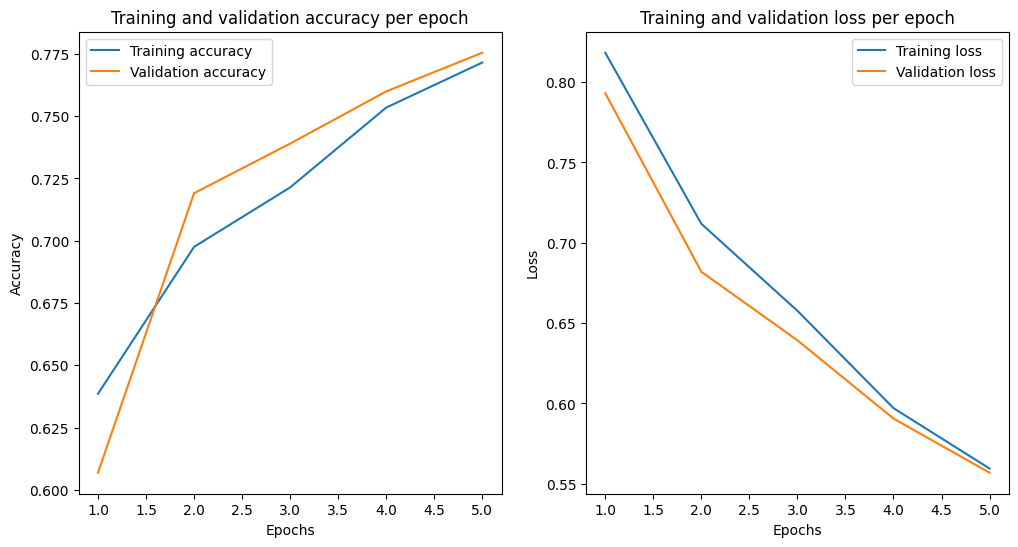

In [7]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Training and validation accuracy per epoch')
plt.plot(epochs,training_accuracy, label='Training accuracy')
plt.plot(epochs,validation_accuracy, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Training and validation loss per epoch')
plt.plot(epochs,training_loss, label='Training loss')
plt.plot(epochs,validation_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [8]:
predictions = model.predict(test_batch)

115/115 ━━━━━━━━━━━━━━━━━━━━ 121s 1s/step


[0 1 2]


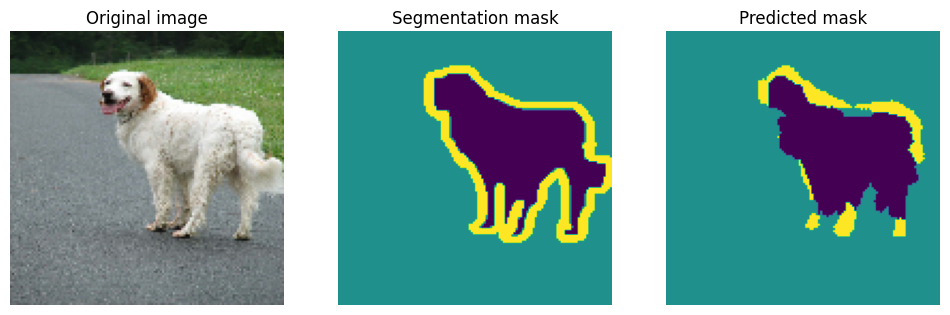

In [9]:
random_index = np.random.randint(0, len(test_batch))
image, mask = next(iter(test.skip(random_index).take(1)))
prediction = predictions[random_index]
prediction = np.argmax(prediction, axis=-1)
print(np.unique(prediction))
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original image')
plt.axis('off')
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title('Segmentation mask')
plt.axis('off')
plt.imshow(mask)

plt.subplot(1, 3, 3)
plt.title('Predicted mask')
plt.axis('off')
plt.imshow(prediction)
plt.show()

Both training and validation accuracy are increasing, and loss is decreasing. The validation accuracy is consistently higher than training accuracy, which is unusual and may indicate that the validation set is easier or that there's some form of overfitting. However, the model capture the outline of the pet accurately if we check the predicted mask.

Train a CNN for semantic segmentation with skip connections (as in U-Net)

Evaluate and visualize the results as before.

### CNN with skip connections idea
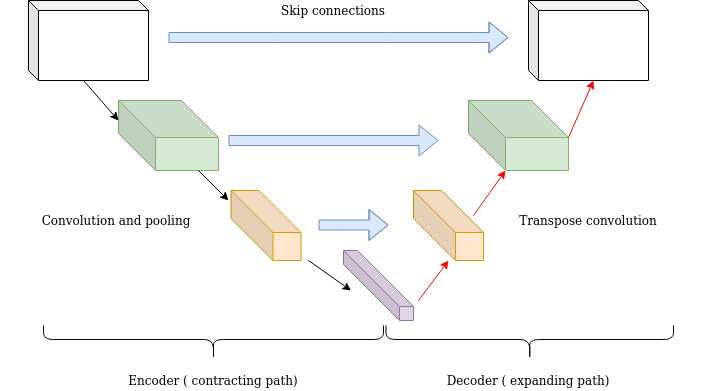



In [10]:
def cnn_skip():
    inputs = layers.Input(shape=(128, 128, 3))

    # Encoder
    conv1 = layers.Conv2D(32, 3, activation='relu', padding='same')(inputs)
    pool1 = layers.MaxPool2D(2)(conv1)
    conv2 = layers.Conv2D(64, 3, activation='relu', padding='same')(pool1)
    pool2 = layers.MaxPool2D(2)(conv2)
    conv3 = layers.Conv2D(128, 3, activation='relu', padding='same')(pool2)
    pool3 = layers.MaxPool2D(2)(conv3)

    conv4 = layers.Conv2D(256, 3, activation='relu', padding='same')(pool3)

    # Decoder
    up1 = layers.Conv2DTranspose(128, 3, 2,  padding='same')(conv4)
    concat1 = layers.Concatenate()([up1, conv3])  # Skip connection
    up2 = layers.Conv2DTranspose(64, 3, 2, padding='same')(concat1)
    concat2 = layers.Concatenate()([up2, conv2])  # Skip connection
    up3 = layers.Conv2DTranspose(32, 3,2 , padding='same')(concat2)
    concat3 = layers.Concatenate()([up3, conv1])  # Skip connection
    output = layers.Conv2D(3, 1, padding='same', activation='softmax')(concat3)

    return keras.Model(inputs=inputs, outputs=output)

model = cnn_skip()

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_batch,
                    validation_data=val_batch,
                    epochs=5)

Epoch 1/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 423s 5s/step - accuracy: 0.6180 - loss: 0.8859 - val_accuracy: 0.7047 - val_loss: 0.7307
Epoch 2/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 459s 5s/step - accuracy: 0.7077 - loss: 0.7035 - val_accuracy: 0.6768 - val_loss: 0.7421
Epoch 3/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 422s 5s/step - accuracy: 0.7355 - loss: 0.6361 - val_accuracy: 0.7564 - val_loss: 0.5928
Epoch 4/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 422s 5s/step - accuracy: 0.7635 - loss: 0.5800 - val_accuracy: 0.7568 - val_loss: 0.5970
Epoch 5/5
92/92 ━━━━━━━━━━━━━━━━━━━━ 420s 5s/step - accuracy: 0.7732 - loss: 0.5580 - val_accuracy: 0.7819 - val_loss: 0.5428


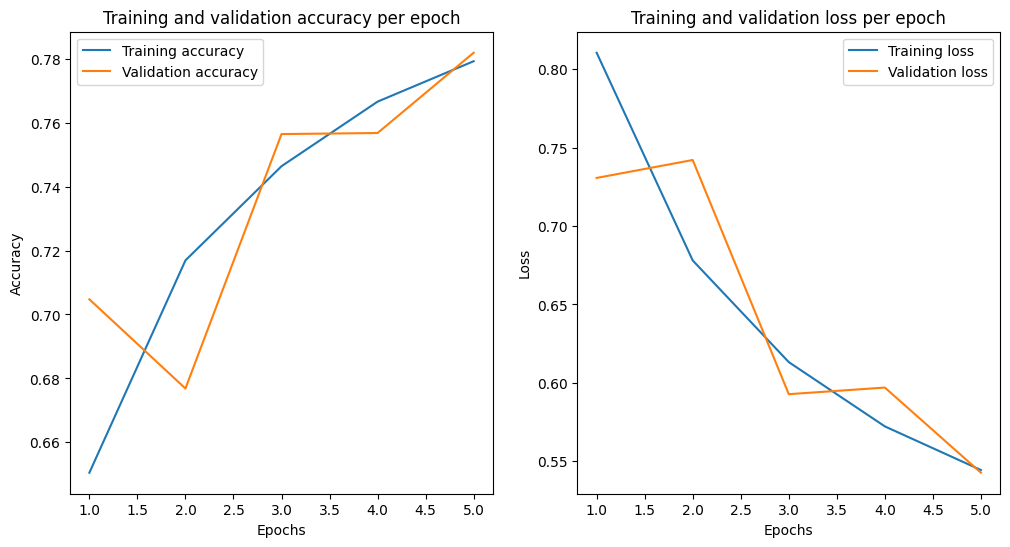

In [12]:
training_loss = history.history['loss']
validation_loss = history.history['val_loss']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']
epochs = range(1, len(training_loss) + 1)

plt.figure(figsize=(12,6))
plt.subplot(1, 2, 1)
plt.title('Training and validation accuracy per epoch')
plt.plot(epochs,training_accuracy, label='Training accuracy')
plt.plot(epochs,validation_accuracy, label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.title('Training and validation loss per epoch')
plt.plot(epochs,training_loss, label='Training loss')
plt.plot(epochs,validation_loss, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [13]:
predictions = model.predict(test_batch)

115/115 ━━━━━━━━━━━━━━━━━━━━ 160s 1s/step


[0 1 2]


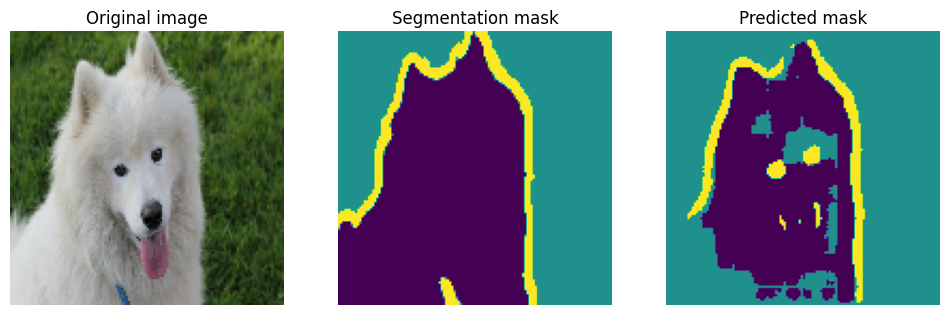

In [14]:
random_index = np.random.randint(0, len(test_batch))
image, mask = next(iter(test.skip(random_index).take(1)))
prediction = predictions[random_index]
prediction = np.argmax(prediction, axis=-1)
print(np.unique(prediction))
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
plt.title('Original image')
plt.axis('off')
plt.imshow(image)

plt.subplot(1, 3, 2)
plt.title('Segmentation mask')
plt.axis('off')
plt.imshow(mask)

plt.subplot(1, 3, 3)
plt.title('Predicted mask')
plt.axis('off')
plt.imshow(prediction)
plt.show()

Both the training and validation accuracy curves are improving, which indicates that the model is learning from the data. Meanwhile,training and validation loss curves are decreasing, which suggests that the model is converging well. Finally, the model shows promising trends in training but struggles with accurate segmentation of pets in the predicted mask (for example, check the eyes).

# Second question - Object Detection

For object detection, you will need to find bounding boxes that correspond to the pet objects in the segmentation masks. To create a bounding box for each pet, you can:

- Identify the non-background pixels in the segmentation mask.

- Compute the minimum and maximum coordinates (xmin, xmax, ymin, ymax) that enclose all the pet pixels. This will give you a bounding box for each image around the pet object.


Different values for the mask: [0 1 2]
Coordinate of 0:(46, 90)
Coordinate of 1:(116, 7)
Coordinate of 2:(51, 23)


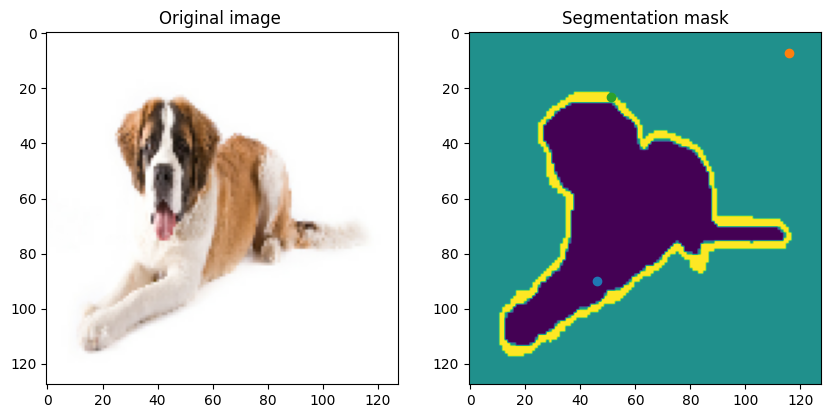

In [15]:
image, mask = next(iter(train.skip(random_index).take(1)))

print('Different values for the mask:', np.unique(mask))

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.title(f'Original image ')
plt.imshow(image)

plt.subplot(1, 2, 2)
plt.title('Segmentation mask')
plt.imshow(mask)
for i in np.unique(mask):
    point = np.argwhere(mask == int(i))[:, :2]
    random_point = np.random.randint(0, len(point))
    plt.scatter(point[random_point][1], point[random_point][0])
    print(f'Coordinate of {i}:{point[random_point][1], point[random_point][0]}')
plt.show()

Looking at the image, the value for the pet is 0, the value for the background is 1 and the value for the contour is 2

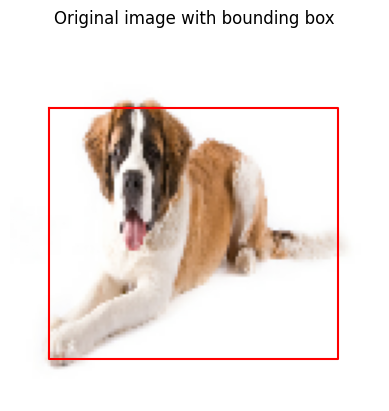

In [16]:
xmin,ymin,xmax,ymax = get_bounding_box(mask)
boxes = [[xmin,ymin,xmax,ymax]]
draw_boxes(image,boxes)

Using a Pre-trained YOLO model:

- Download a pre-trained YOLO model.

- Convert the model weight (.weight) to a Keras-compatible (.h5) file.

- Load the model and test it on an image by normalizing the image and applying the model for predictions.

- Show the detection results using bounding boxes drawn on the image.

/usr/local/lib/python3.10/dist-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
[(1, 13, 13, 255), (1, 26, 26, 255), (1, 52, 52, 255)]
zebra 94.91059184074402
zebra 99.86327290534973
zebra 96.87086343765259


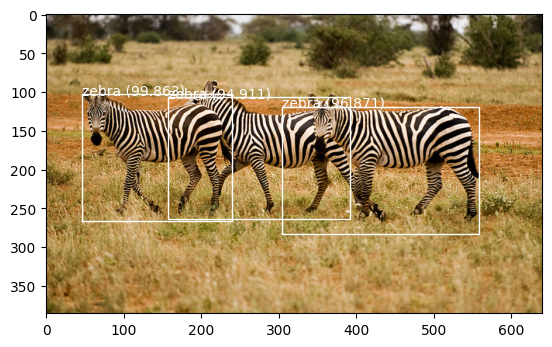

In [17]:
# load yolov3 model
model = load_model('yolov3.h5')
# define the expected input shape for the model
input_w, input_h = 416, 416
# define our new photo
photo_filename = 'zebra.jpg'
# load and prepare image
image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))
# make prediction
yhat = model.predict(image)
# summarize the shape of the list of arrays
print([a.shape for a in yhat])
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]
# define the probability threshold for detected objects
class_threshold = 0.6
boxes = list()
for i in range(len(yhat)):
	# decode the output of the network
	boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
# correct the sizes of the bounding boxes for the shape of the image
correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
# suppress non-maximal boxes
do_nms(boxes, 0.5)
# define the labels
labels = ["person", "bicycle", "car", "motorbike", "aeroplane", "bus", "train", "truck",
	"boat", "traffic light", "fire hydrant", "stop sign", "parking meter", "bench",
	"bird", "cat", "dog", "horse", "sheep", "cow", "elephant", "bear", "zebra", "giraffe",
	"backpack", "umbrella", "handbag", "tie", "suitcase", "frisbee", "skis", "snowboard",
	"sports ball", "kite", "baseball bat", "baseball glove", "skateboard", "surfboard",
	"tennis racket", "bottle", "wine glass", "cup", "fork", "knife", "spoon", "bowl", "banana",
	"apple", "sandwich", "orange", "broccoli", "carrot", "hot dog", "pizza", "donut", "cake",
	"chair", "sofa", "pottedplant", "bed", "diningtable", "toilet", "tvmonitor", "laptop", "mouse",
	"remote", "keyboard", "cell phone", "microwave", "oven", "toaster", "sink", "refrigerator",
	"book", "clock", "vase", "scissors", "teddy bear", "hair drier", "toothbrush"]
# get the details of the detected objects
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)
# summarize what we found
for i in range(len(v_boxes)):
	print(v_labels[i], v_scores[i])
# draw what we found
draw_boxes_yolo(photo_filename, v_boxes, v_labels, v_scores)

Evaluate the model's performance on the oxford_iiit_pet dataset using the known bounding boxes.

Calculate mAP at different IoU thresholds (mAP{0.25},mAP{0.5},mAP{0.75},mAP{0.95}).


In [18]:
# Load ground truth and prediction labels
gt_labels = load_labels('gt_label.txt')
pred_labels = load_labels('pred_label.txt')

# Evaluate mAP
mAP_results = evaluate_mAP(gt_labels, pred_labels)
print("mAP Results:", mAP_results)

mAP Results: {0.25: 0.9283824677395361, 0.5: 0.8952427155390449, 0.75: 0.7074030093474988, 0.95: 0.0009595007085297782}


The high mAP values at lower IoU thresholds indicate the model can detect and roughly locate objects well.